In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.10.0


## 1. Data Loading & Initial Setup

In [2]:
# Load the datasets
train_df = pd.read_csv('../data/Raw/train.csv')
test_df = pd.read_csv('../data/Raw/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Create a copy for preprocessing
df_train = train_df.copy()
df_test = test_df.copy()

# Display basic information
print("\nTraining Data Info:")
print(df_train.info())
print(f"\nMissing values in training data:")
print(df_train.isnull().sum())

print(f"\nMissing values in test data:")
print(df_test.isnull().sum())

Training data shape: (8693, 14)
Test data shape: (4277, 13)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

Missing values in training data:
PassengerId       0
Ho

## 2. Feature Engineering

In [3]:
def engineer_features(df):
    df = df.copy()

    # 1. Extract cabin information (Deck, Cabin Number, Side)
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype('float', errors='ignore')
    df['Side'] = df['Cabin'].str.split('/').str[2]

    # 2. Create total spending feature
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_cols].sum(axis=1)

    # 3. Create age groups (from EDA insights)
    df['AgeGroup'] = pd.cut(df['Age'],
                           bins=[0, 12, 18, 35, 60, 100],
                           labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'],
                           right=False)

    # 4. Create spending indicators (binary features)
    for col in spending_cols:
        df[f'{col}_Used'] = (df[col] > 0).astype(int)
    df['AnySpending'] = (df['TotalSpending'] > 0).astype(int)

    # 5. Family size (extract from PassengerId pattern)
    df['GroupId'] = df['PassengerId'].str.split('_').str[0]
    group_sizes = df['GroupId'].value_counts()
    df['GroupSize'] = df['GroupId'].map(group_sizes)
    df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

    # 6. VIP spending ratio (VIP passengers should spend more)
    # Handle NaN values in VIP column
    vip_filled = df['VIP'].fillna(False).astype(int)
    df['VIP_SpendingRatio'] = df['TotalSpending'] / (vip_filled + 1)

    # 7. Cabin number binning (if cabin number exists)
    df['CabinNum_Binned'] = pd.cut(df['CabinNum'], bins=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

    # 8. Create interaction features based on EDA
    cryo_filled = df['CryoSleep'].fillna(False).astype(int)
    vip_filled = df['VIP'].fillna(False).astype(int)
    df['CryoSleep_Age'] = cryo_filled * df['Age'].fillna(df['Age'].median())
    df['VIP_TotalSpending'] = vip_filled * df['TotalSpending']

    print("Feature engineering completed!")
    print(f"New features created: {list(set(df.columns) - set(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']))}")

    return df

# Apply feature engineering to both datasets
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print(f"\nTraining data shape after feature engineering: {df_train.shape}")
print(f"Test data shape after feature engineering: {df_test.shape}")

Feature engineering completed!
New features created: ['VRDeck_Used', 'FoodCourt_Used', 'CabinNum', 'AgeGroup', 'Spa_Used', 'Deck', 'ShoppingMall_Used', 'GroupSize', 'GroupId', 'AnySpending', 'VIP_TotalSpending', 'Side', 'RoomService_Used', 'CabinNum_Binned', 'IsAlone', 'CryoSleep_Age', 'VIP_SpendingRatio', 'TotalSpending']
Feature engineering completed!
New features created: ['VRDeck_Used', 'FoodCourt_Used', 'CabinNum', 'AgeGroup', 'Spa_Used', 'Deck', 'ShoppingMall_Used', 'GroupSize', 'GroupId', 'AnySpending', 'VIP_TotalSpending', 'Side', 'RoomService_Used', 'CabinNum_Binned', 'IsAlone', 'CryoSleep_Age', 'VIP_SpendingRatio', 'TotalSpending']

Training data shape after feature engineering: (8693, 32)
Test data shape after feature engineering: (4277, 31)


In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending,AgeGroup,RoomService_Used,FoodCourt_Used,ShoppingMall_Used,Spa_Used,VRDeck_Used,AnySpending,GroupId,GroupSize,IsAlone,VIP_SpendingRatio,CabinNum_Binned,CryoSleep_Age,VIP_TotalSpending
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0,Adult,0,0,0,0,0,0,0001,1,1,0.0,Low,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0,Young Adult,1,1,1,1,1,1,0002,1,1,736.0,Low,0.0,0.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0,Adult,1,1,0,1,1,1,0003,2,0,5191.5,Low,0.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0,Young Adult,0,1,1,1,1,1,0003,2,0,5176.0,Low,0.0,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0,Teen,1,1,1,1,1,1,0004,1,1,1091.0,Low,0.0,0.0


## 3. Missing Value Handling

In [5]:
def handle_missing_values(df_train, df_test):
    """
    Handle missing values using different strategies based on feature type and EDA insights
    """
    # Combine datasets for consistent imputation
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    train_size = len(df_train)

    # 1. Categorical variables - Mode imputation
    categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup', 'CabinNum_Binned']

    for col in categorical_cols:
        if combined_df[col].isnull().sum() > 0:
            mode_value = combined_df[col].mode()[0] if len(combined_df[col].mode()) > 0 else 'Unknown'
            combined_df[col].fillna(mode_value, inplace=True)
            print(f"Filled {col} missing values with mode: {mode_value}")

    # 2. Boolean variables - Mode imputation
    boolean_cols = ['CryoSleep', 'VIP']
    for col in boolean_cols:
        if combined_df[col].isnull().sum() > 0:
            mode_value = combined_df[col].mode()[0]
            combined_df[col].fillna(mode_value, inplace=True)
            print(f"Filled {col} missing values with mode: {mode_value}")

    # 3. Numerical variables - Different strategies based on EDA insights

    # Age: Use median within groups (HomePlanet, VIP status)
    if combined_df['Age'].isnull().sum() > 0:
        for planet in combined_df['HomePlanet'].unique():
            for vip in combined_df['VIP'].unique():
                mask = (combined_df['HomePlanet'] == planet) & (combined_df['VIP'] == vip)
                median_age = combined_df[mask]['Age'].median()
                if pd.notna(median_age):
                    combined_df.loc[mask & combined_df['Age'].isnull(), 'Age'] = median_age

        # Fill any remaining with overall median
        if combined_df['Age'].isnull().sum() > 0:
            combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
        print(f"Filled Age missing values using group-based median")

    # Spending variables: Fill with 0 (makes sense - no spending means 0)
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_cols:
        if combined_df[col].isnull().sum() > 0:
            combined_df[col].fillna(0, inplace=True)
            print(f"Filled {col} missing values with 0")

    # Cabin number: Fill with median within deck
    if combined_df['CabinNum'].isnull().sum() > 0:
        for deck in combined_df['Deck'].unique():
            if pd.notna(deck):
                deck_median = combined_df[combined_df['Deck'] == deck]['CabinNum'].median()
                if pd.notna(deck_median):
                    mask = (combined_df['Deck'] == deck) & combined_df['CabinNum'].isnull()
                    combined_df.loc[mask, 'CabinNum'] = deck_median
        print(f"Filled CabinNum missing values using deck-based median")

    # Recalculate derived features after imputation
    combined_df['TotalSpending'] = combined_df[spending_cols].sum(axis=1)
    combined_df['AnySpending'] = (combined_df['TotalSpending'] > 0).astype(int)

    for col in spending_cols:
        combined_df[f'{col}_Used'] = (combined_df[col] > 0).astype(int)

    # Split back to train and test
    df_train_imputed = combined_df[:train_size].copy()
    df_test_imputed = combined_df[train_size:].copy()

    print(f"\nMissing values after imputation:")
    print(f"Training data: {df_train_imputed.isnull().sum().sum()}")
    print(f"Test data: {df_test_imputed.isnull().sum().sum()}")

    return df_train_imputed, df_test_imputed

# Apply missing value handling
df_train, df_test = handle_missing_values(df_train, df_test)

Filled HomePlanet missing values with mode: Earth
Filled Destination missing values with mode: TRAPPIST-1e
Filled Deck missing values with mode: F
Filled Side missing values with mode: S
Filled AgeGroup missing values with mode: Young Adult
Filled CabinNum_Binned missing values with mode: Low
Filled CryoSleep missing values with mode: False
Filled VIP missing values with mode: False
Filled Age missing values using group-based median
Filled RoomService missing values with 0
Filled FoodCourt missing values with 0
Filled ShoppingMall missing values with 0
Filled Spa missing values with 0
Filled VRDeck missing values with 0
Filled CabinNum missing values using deck-based median

Missing values after imputation:
Training data: 399
Test data: 4471


## 4. Outlier Detection and Treatment

In [6]:
def handle_outliers(df_train, df_test, method='cap'):
    """
    Handle outliers using IQR method
    method: 'cap' (winsorization) or 'remove'
    """
    # Define columns to check for outliers
    outlier_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending', 'CabinNum']

    # Calculate outlier bounds from training data only
    outlier_bounds = {}

    for col in outlier_cols:
        if col in df_train.columns and df_train[col].notna().sum() > 0:
            Q1 = df_train[col].quantile(0.25)
            Q3 = df_train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_bounds[col] = {'lower': lower_bound, 'upper': upper_bound}

            # Count outliers before treatment
            outliers_before = ((df_train[col] < lower_bound) | (df_train[col] > upper_bound)).sum()

            if method == 'cap':
                # Cap outliers (Winsorization)
                df_train[col] = df_train[col].clip(lower=lower_bound, upper=upper_bound)
                df_test[col] = df_test[col].clip(lower=lower_bound, upper=upper_bound)

                print(f"{col}: Capped {outliers_before} outliers (bounds: [{lower_bound:.2f}, {upper_bound:.2f}])")

            elif method == 'remove':
                # Remove outliers (only from training data)
                outlier_mask = (df_train[col] < lower_bound) | (df_train[col] > upper_bound)
                df_train = df_train[~outlier_mask]
                print(f"{col}: Removed {outliers_before} outliers")

    # Recalculate TotalSpending after outlier treatment
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df_train['TotalSpending'] = df_train[spending_cols].sum(axis=1)
    df_test['TotalSpending'] = df_test[spending_cols].sum(axis=1)

    return df_train, df_test, outlier_bounds

# Apply outlier handling (using capping method)
df_train, df_test, outlier_info = handle_outliers(df_train, df_test, method='cap')

print(f"\nFinal training data shape: {df_train.shape}")
print(f"Final test data shape: {df_test.shape}")

Age: Capped 162 outliers (bounds: [-5.50, 62.50])
RoomService: Capped 1906 outliers (bounds: [-61.50, 102.50])
FoodCourt: Capped 1916 outliers (bounds: [-91.50, 152.50])
ShoppingMall: Capped 1879 outliers (bounds: [-33.00, 55.00])
Spa: Capped 1833 outliers (bounds: [-79.50, 132.50])
VRDeck: Capped 1849 outliers (bounds: [-60.00, 100.00])
TotalSpending: Capped 934 outliers (bounds: [-2161.50, 3602.50])
CabinNum: Capped 0 outliers (bounds: [-1042.00, 2198.00])

Final training data shape: (8693, 32)
Final test data shape: (4277, 32)


## 5. Categorical Encoding

In [7]:
def encode_categorical_features(df_train, df_test):
    """
    Encode categorical features using appropriate methods based on EDA insights
    """
    # Make copies
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()

    # Store encoders for later use
    encoders = {}

    # 1. Binary encoding for boolean variables
    binary_cols = ['CryoSleep', 'VIP']
    for col in binary_cols:
        df_train_encoded[col] = df_train_encoded[col].astype(int)
        df_test_encoded[col] = df_test_encoded[col].astype(int)
        print(f"Binary encoded: {col}")

    # 2.high-cardinality categorical variables
    label_encode_cols = ['GroupId']  # High cardinality

    for col in label_encode_cols:
        if col in df_train_encoded.columns:
            # Use frequency encoding
            freq_map = df_train_encoded[col].value_counts().to_dict()

            df_train_encoded[f'{col}_freq'] = df_train_encoded[col].map(freq_map)
            df_test_encoded[f'{col}_freq'] = df_test_encoded[col].map(freq_map)

            # Fill missing with 1 (single occurrence)
            df_train_encoded[f'{col}_freq'].fillna(1, inplace=True)
            df_test_encoded[f'{col}_freq'].fillna(1, inplace=True)

    # 3. One-hot encoding for nominal categorical variables with few categories
    onehot_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']

    for col in onehot_cols:
        if col in df_train_encoded.columns:
            # Get unique values from both train and test
            unique_values = df_train_encoded[col].unique()
            unique_values = [v for v in unique_values if pd.notna(v)]  # Remove NaN

            # Create dummy variables
            for value in unique_values:
                col_name = f'{col}_{value}'
                df_train_encoded[col_name] = (df_train_encoded[col] == value).astype(int)
                df_test_encoded[col_name] = (df_test_encoded[col] == value).astype(int)

            print(f"One-hot encoded: {col} -> {len(unique_values)} categories")

    # 4. Ordinal encoding for ordinal categorical variables
    ordinal_cols = {'AgeGroup': ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'],
                   'CabinNum_Binned': ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High']}

    for col, order in ordinal_cols.items():
        if col in df_train_encoded.columns:
            # Create mapping
            ordinal_map = {val: idx for idx, val in enumerate(order)}

            df_train_encoded[f'{col}_ordinal'] = df_train_encoded[col].map(ordinal_map)
            df_test_encoded[f'{col}_ordinal'] = df_test_encoded[col].map(ordinal_map)

            # Fill missing with median
            median_val = np.median([v for v in ordinal_map.values()])
            df_train_encoded[f'{col}_ordinal'].fillna(median_val, inplace=True)
            df_test_encoded[f'{col}_ordinal'].fillna(median_val, inplace=True)

            encoders[f'{col}_ordinal'] = ordinal_map
            print(f"Ordinal encoded: {col}")

    # Drop original categorical columns that were encoded
    cols_to_drop = onehot_cols + list(ordinal_cols.keys()) + label_encode_cols
    cols_to_drop = [col for col in cols_to_drop if col in df_train_encoded.columns]

    df_train_encoded.drop(columns=cols_to_drop, inplace=True)
    df_test_encoded.drop(columns=cols_to_drop, inplace=True)

    print(f"\nDropped original categorical columns: {cols_to_drop}")
    print(f"Training data shape after encoding: {df_train_encoded.shape}")
    print(f"Test data shape after encoding: {df_test_encoded.shape}")

    return df_train_encoded, df_test_encoded, encoders

# Apply categorical encoding
df_train, df_test, encoding_info = encode_categorical_features(df_train, df_test)

Binary encoded: CryoSleep
Binary encoded: VIP
One-hot encoded: HomePlanet -> 3 categories
One-hot encoded: Destination -> 3 categories
One-hot encoded: Deck -> 8 categories
One-hot encoded: Side -> 2 categories
Ordinal encoded: AgeGroup
Ordinal encoded: CabinNum_Binned

Dropped original categorical columns: ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup', 'CabinNum_Binned', 'GroupId']
Training data shape after encoding: (8693, 44)
Test data shape after encoding: (4277, 44)


## 6. Feature Scaling

In [8]:
def scale_features(df_train, df_test):
    """
    Scale numerical features using StandardScaler
    """
    # Identify numerical columns to scale
    numerical_cols_to_scale = [
        'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'TotalSpending', 'CabinNum', 'GroupSize', 'VIP_SpendingRatio',
        'CryoSleep_Age', 'VIP_TotalSpending'
    ]

    # Filter to existing columns
    numerical_cols_to_scale = [col for col in numerical_cols_to_scale if col in df_train.columns]

    # Also scale encoded features that might need it
    encoded_cols = [col for col in df_train.columns if '_encoded' in col or '_ordinal' in col]
    numerical_cols_to_scale.extend(encoded_cols)

    # Initialize scaler
    scaler = StandardScaler()

    # Fit on training data and transform both
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    if numerical_cols_to_scale:
        # Fit on training data
        scaler.fit(df_train[numerical_cols_to_scale])

        # Transform both datasets
        df_train_scaled[numerical_cols_to_scale] = scaler.transform(df_train[numerical_cols_to_scale])
        df_test_scaled[numerical_cols_to_scale] = scaler.transform(df_test[numerical_cols_to_scale])

        print(f"Scaled {len(numerical_cols_to_scale)} numerical features:")
        print(numerical_cols_to_scale)

    return df_train_scaled, df_test_scaled, scaler

# Apply feature scaling
df_train, df_test, scaler_info = scale_features(df_train, df_test)

Scaled 14 numerical features:
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending', 'CabinNum', 'GroupSize', 'VIP_SpendingRatio', 'CryoSleep_Age', 'VIP_TotalSpending', 'AgeGroup_ordinal', 'CabinNum_Binned_ordinal']


## 7. Final Data Preparation

In [9]:
# Define columns to exclude from features
exclude_cols = ['PassengerId', 'Name', 'Cabin', 'Transported']  # Keep PassengerId for submission

# Get feature columns
feature_cols = [col for col in df_train.columns if col not in exclude_cols]

print(f"Total features for modeling: {len(feature_cols)}")
print("Feature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Prepare training data
X = df_train[feature_cols]
y = df_train['Transported'].astype(int)

# Prepare test data
X_test = df_test[feature_cols]
test_ids = df_test['PassengerId']

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData splits:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nTarget distribution in training set:")
print(f"Not Transported (0): {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"Transported (1): {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")

# Check for any remaining missing values
print(f"\nFinal check - Missing values:")
print(f"X_train: {X_train.isnull().sum().sum()}")
print(f"X_val: {X_val.isnull().sum().sum()}")
print(f"X_test: {X_test.isnull().sum().sum()}")

Total features for modeling: 40
Feature columns:
 1. CryoSleep
 2. Age
 3. VIP
 4. RoomService
 5. FoodCourt
 6. ShoppingMall
 7. Spa
 8. VRDeck
 9. CabinNum
10. TotalSpending
11. RoomService_Used
12. FoodCourt_Used
13. ShoppingMall_Used
14. Spa_Used
15. VRDeck_Used
16. AnySpending
17. GroupSize
18. IsAlone
19. VIP_SpendingRatio
20. CryoSleep_Age
21. VIP_TotalSpending
22. GroupId_freq
23. HomePlanet_Europa
24. HomePlanet_Earth
25. HomePlanet_Mars
26. Destination_TRAPPIST-1e
27. Destination_PSO J318.5-22
28. Destination_55 Cancri e
29. Deck_B
30. Deck_F
31. Deck_A
32. Deck_G
33. Deck_E
34. Deck_D
35. Deck_C
36. Deck_T
37. Side_P
38. Side_S
39. AgeGroup_ordinal
40. CabinNum_Binned_ordinal

Data splits:
Training set: (6954, 40)
Validation set: (1739, 40)
Test set: (4277, 40)

Target distribution in training set:
Not Transported (0): 3452 (49.6%)
Transported (1): 3502 (50.4%)

Final check - Missing values:
X_train: 0
X_val: 0
X_test: 0


## 8. Deep Learning Model Implementation

In [10]:
# Feature importance analysis and selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Use Random Forest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Select fewer features - only top 25 instead of 50
k_features = min(25, X_train.shape[1])  # Select best 25 features
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

print(f"\nFeature selection completed!")
print(f"Original features: {X_train.shape[1]}")
print(f"Selected features: {X_train_selected.shape[1]}")

# Keep only the most important features from RF as well
selected_features = feature_importance.head(k_features)['feature'].tolist()
print(f"\nSelected feature names: {selected_features}")

# Update the datasets
X_train = pd.DataFrame(X_train_selected)
X_val = pd.DataFrame(X_val_selected)
X_test = pd.DataFrame(X_test_selected)

Top 20 Most Important Features:
                    feature  importance
8                  CabinNum    0.119204
9             TotalSpending    0.106643
18        VIP_SpendingRatio    0.100310
1                       Age    0.085446
19            CryoSleep_Age    0.062396
6                       Spa    0.037996
3               RoomService    0.032601
7                    VRDeck    0.032489
39  CabinNum_Binned_ordinal    0.032020
15              AnySpending    0.029808
4                 FoodCourt    0.029781
0                 CryoSleep    0.029405
16                GroupSize    0.023731
21             GroupId_freq    0.023719
38         AgeGroup_ordinal    0.022808
5              ShoppingMall    0.018928
13                 Spa_Used    0.015894
23         HomePlanet_Earth    0.015816
31                   Deck_G    0.015051
22        HomePlanet_Europa    0.013364

Feature selection completed!
Original features: 40
Selected features: 25

Selected feature names: ['CabinNum', 'TotalSpending',

In [11]:
def create_neural_network(input_dim):
    """
    Create a simpler but more effective neural network
    """
    model = keras.Sequential([
        # Simpler architecture that works better
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Use a lower learning rate for better convergence
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the improved model
input_dimension = X_train.shape[1]
model = create_neural_network(input_dimension)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
# Simple callbacks - let it train longer
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=25,  # Much more patience
        restore_best_weights=True,
        verbose=1,
        min_delta=0.00001  # Very small improvement threshold
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,  # More patience here too
        min_lr=1e-7,
        verbose=1
    )
]

# Train with more balanced class weights
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")

# Train the model with improved settings
print("Training the neural network...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # More epochs
    batch_size=32,  # Smaller batch for better gradient updates
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict  # Handle imbalanced data
)

print("\nTraining completed!")

Class weights: {0: np.float64(1.007242178447277), 1: np.float64(0.9928612221587664)}
Training the neural network...
Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5373 - loss: 0.8880 - val_accuracy: 0.7361 - val_loss: 0.5641 - learning_rate: 5.0000e-04
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6757 - loss: 0.6268 - val_accuracy: 0.7366 - val_loss: 0.5074 - learning_rate: 5.0000e-04
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7068 - loss: 0.5763 - val_accuracy: 0.7407 - val_loss: 0.4856 - learning_rate: 5.0000e-04
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7239 - loss: 0.5568 - val_accuracy: 0.7389 - val_loss: 0.4828 - learning_rate: 5.0000e-04
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7247 - loss: 0.5547 - val_accuracy: 0.7470 - val_loss: 0.4785 - learning_rate: 5.0000e-04
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7383 - loss: 0.5379 - val_accura

In [13]:
# Evaluate the model
print("Evaluating the model...")

# Make predictions
y_train_pred = (model.predict(X_train) > 0.5).astype(int)
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
print("\nConfusion Matrix (Validation Set):")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

Evaluating the model...
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training Accuracy: 0.7872
Validation Accuracy: 0.7786

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       863
           1       0.78      0.78      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739


Confusion Matrix (Validation Set):
[[674 189]
 [196 680]]


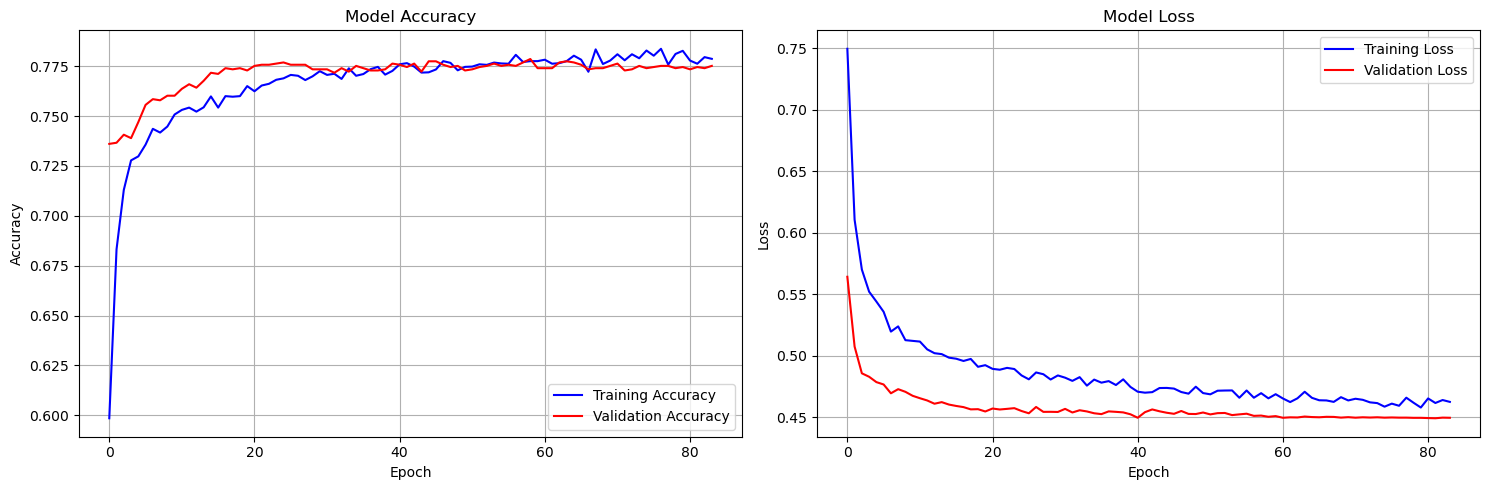


Best Validation Accuracy: 0.7786


In [14]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")

In [15]:
# Make predictions on test data
print("Making predictions on test data...")
test_predictions = model.predict(X_test)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Create submission dataframe
submission_df = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': test_predictions_binary.flatten().astype(bool)  
})

# Display first few predictions
print("First 10 predictions:")
print(submission_df.head(10))

# Save submission file
submission_path = '../submission/submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"\nSubmission file saved to: {submission_path}")

# Display submission statistics
print(f"\nSubmission Statistics:")
print(f"Total predictions: {len(submission_df)}")
print(f"Predicted Transported (1): {submission_df['Transported'].sum()} ({submission_df['Transported'].mean():.1%})")
print(f"Predicted Not Transported (0): {(submission_df['Transported'] == 0).sum()} ({(submission_df['Transported'] == 0).mean():.1%})")

Making predictions on test data...
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
First 10 predictions:
     PassengerId  Transported
8693     0013_01         True
8694     0018_01        False
8695     0019_01         True
8696     0021_01        False
8697     0023_01         True
8698     0027_01        False
8699     0029_01         True
8700     0032_01         True
8701     0032_02         True
8702     0033_01         True

Submission file saved to: ../submission/submission.csv

Submission Statistics:
Total predictions: 4277
Predicted Transported (1): 2180 (51.0%)
Predicted Not Transported (0): 2097 (49.0%)


In [16]:
# Save the trained model
model_path = '../src/model/model.h5'
model.save(model_path)
print(f"Model saved to: {model_path}")

# Save the scaler for future use
scaler_path = '../src/model/scaler.pkl'
joblib.dump(scaler_info, scaler_path)
print(f"Scaler saved to: {scaler_path}")

print("\n" + "="*50)
print("DEEP LEARNING MODEL TRAINING COMPLETED!")
print("="*50)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print("Model and scaler saved successfully!")
print("Submission file created!")
print("="*50)

Model saved to: ../src/model/model.h5
Scaler saved to: ../src/model/scaler.pkl

DEEP LEARNING MODEL TRAINING COMPLETED!
Final Validation Accuracy: 0.7786
Best Validation Accuracy: 0.7786
Model and scaler saved successfully!
Submission file created!
